# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

from samples.japan_roof import japan_roof
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases

ckpt_number = 4413
BALLON_WEIGHTS_PATH = "../../logs/pascalvoc20200629T0141/mask_rcnn_pascalvoc_" + str(ckpt_number) + ".h5"  # TODO: update this path

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Configurations

In [2]:
config = japan_roof.PascalVOCConfig()
JAPAN_ROOF_DIR = os.path.join(ROOT_DIR, "/root/japan_roof_dataset_2000_solarpanel")
print(JAPAN_ROOF_DIR)

/root/japan_roof_dataset_2000_solarpanel


In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = japan_roof.PascalVOCDataset()
dataset.load_pascalvoc(JAPAN_ROOF_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

/root/japan_roof_dataset_2000_solarpanel/val/json/[0,11](135.432096E,34.828154N)_center_(135.431664E,34.828506N)min_(135.43252800000002E,34.827802N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[0,11](135.432096E,34.828154N)_center_(135.431664E,34.828506N)min_(135.43252800000002E,34.827802N)_max_zoom_20_size_640x640.png
/root/japan_roof_dataset_2000_solarpanel/val/json/[1,4](135.514130E,34.581710N)_center_(135.513698E,34.582062N)min_(135.514562E,34.581358N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[1,4](135.514130E,34.581710N)_center_(135.513698E,34.582062N)min_(135.514562E,34.581358N)_max_zoom_20_size_640x640.png
/root/japan_roof_dataset_2000_solarpanel/val/json/[0,4](135.426496E,34.828154N)_center_(135.426064E,34.828506N)min_(135.426928E,34.827802N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[0,4](135.426496E,34.828154N)_center_(135.426064E,34.828506N)min_(135.426928E,34.

/root/japan_roof_dataset_2000_solarpanel/val/json/[0,3](135.425696E,34.828154N)_center_(135.425264E,34.828506N)min_(135.426128E,34.827802N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[0,3](135.425696E,34.828154N)_center_(135.425264E,34.828506N)min_(135.426128E,34.827802N)_max_zoom_20_size_640x640.png
/root/japan_roof_dataset_2000_solarpanel/val/json/[0,10](135.563362E,34.640033N)_center_(135.56293000000002E,34.640385N)min_(135.56379400000003E,34.639681N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[0,10](135.563362E,34.640033N)_center_(135.56293000000002E,34.640385N)min_(135.56379400000003E,34.639681N)_max_zoom_20_size_640x640.png
/root/japan_roof_dataset_2000_solarpanel/val/json/[0,9](135.430496E,34.828154N)_center_(135.43006400000002E,34.828506N)min_(135.43092800000002E,34.827802N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[0,9](135.430496E,34.828154N)_center_(135.4300640

/root/japan_roof_dataset_2000_solarpanel/val/json/[1,4](135.558562E,34.639433N)_center_(135.55813E,34.639784999999996N)min_(135.558994E,34.639081N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[1,4](135.558562E,34.639433N)_center_(135.55813E,34.639784999999996N)min_(135.558994E,34.639081N)_max_zoom_20_size_640x640.png
/root/japan_roof_dataset_2000_solarpanel/val/json/[1,3](135.417767E,34.788754N)_center_(135.417335E,34.789106N)min_(135.41819900000002E,34.788402N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[1,3](135.417767E,34.788754N)_center_(135.417335E,34.789106N)min_(135.41819900000002E,34.788402N)_max_zoom_20_size_640x640.png
/root/japan_roof_dataset_2000_solarpanel/val/json/[1,2](135.416967E,34.788754N)_center_(135.416535E,34.789106N)min_(135.41739900000002E,34.788402N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[1,2](135.416967E,34.788754N)_center_(135.416535E,34.789106

/root/japan_roof_dataset_2000_solarpanel/val/json/[0,13](135.565762E,34.640033N)_center_(135.56533000000002E,34.640385N)min_(135.56619400000002E,34.639681N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[0,13](135.565762E,34.640033N)_center_(135.56533000000002E,34.640385N)min_(135.56619400000002E,34.639681N)_max_zoom_20_size_640x640.png
/root/japan_roof_dataset_2000_solarpanel/val/json/[0,2](135.556962E,34.640033N)_center_(135.55653E,34.640385N)min_(135.55739400000002E,34.639681N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[0,2](135.556962E,34.640033N)_center_(135.55653E,34.640385N)min_(135.55739400000002E,34.639681N)_max_zoom_20_size_640x640.png
/root/japan_roof_dataset_2000_solarpanel/val/json/[0,11](135.424167E,34.789354N)_center_(135.42373500000002E,34.789706N)min_(135.42459900000003E,34.789002N)_max_zoom_20_size_640x640.json /root/japan_roof_dataset_2000_solarpanel/val/image/[0,11](135.424167E,34.789354N)_cen

## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /root/Mask_RCNN/logs/pascalvoc20200629T0141/mask_rcnn_pascalvoc_6396.h5
Re-starting from epoch 6396


## Run Detection

In [9]:
import colorsys

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


In [10]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [11]:
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    print('number_of_instances : ', N)
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
#     ax.imshow(masked_image.astype(np.uint8))
#     if auto_show:
#         plt.show()


Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
number_of_instances :  3
image_number :  1
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
number_of_instances :  5
image_number :  2
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  ui

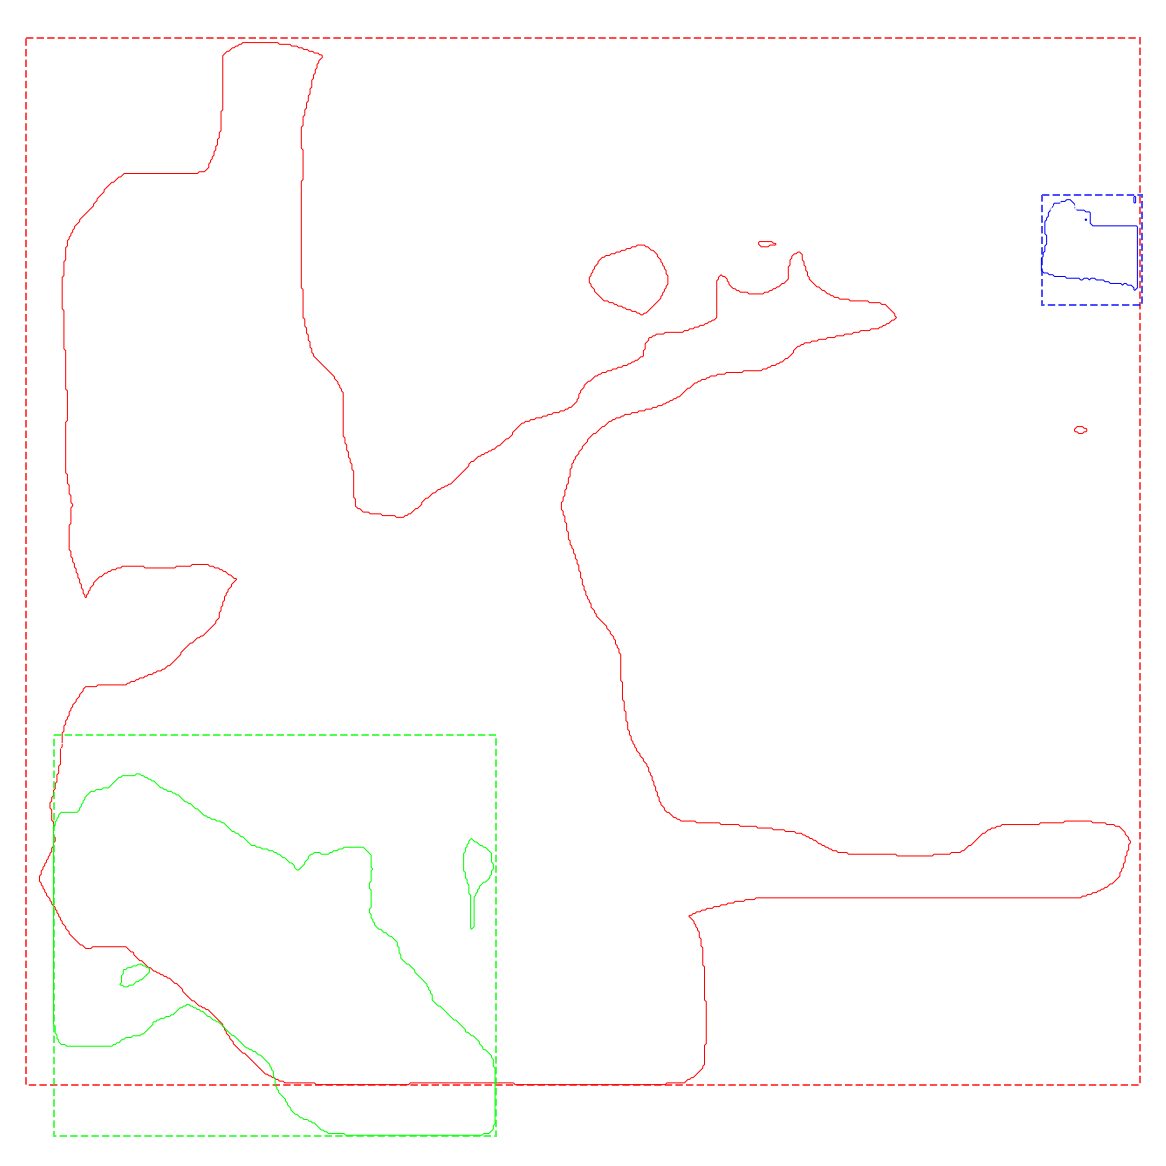

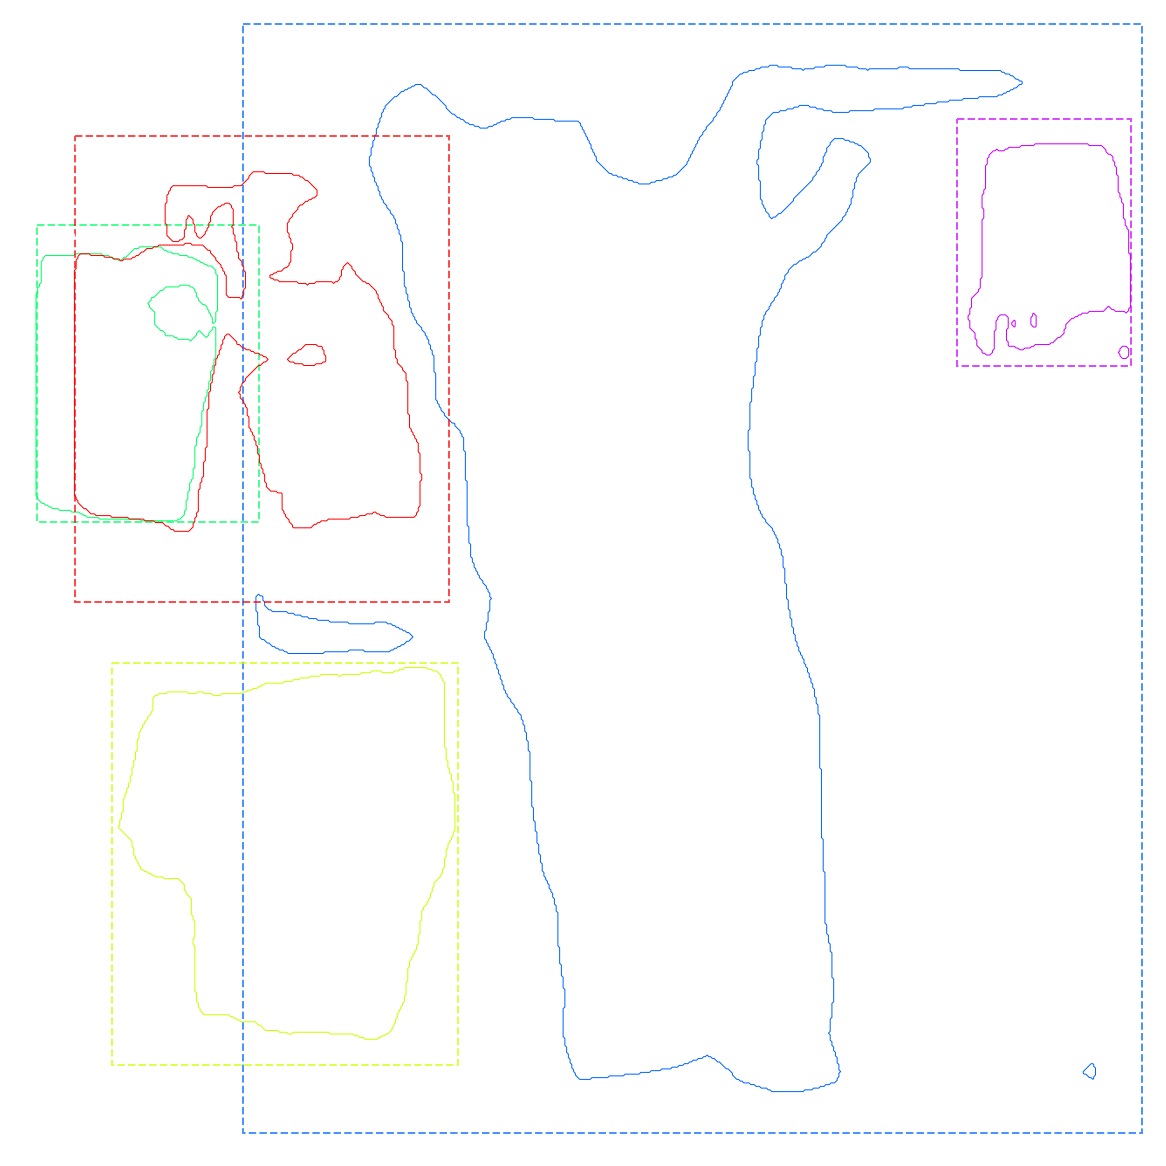

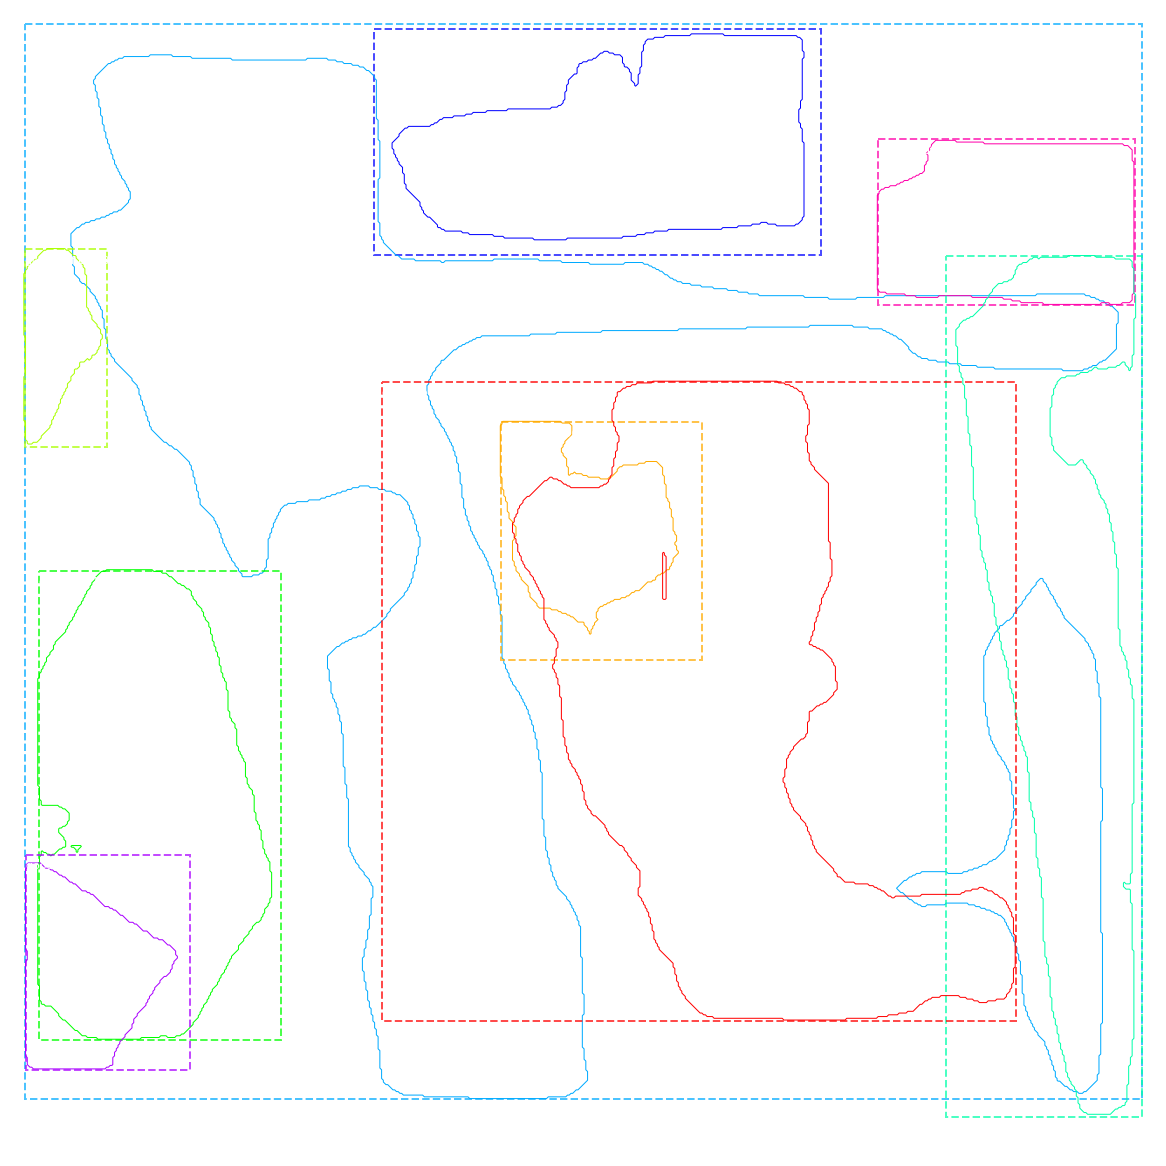

In [12]:
# image_id = random.choice(dataset.image_ids)
# image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
# info = dataset.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                        dataset.image_reference(image_id)))
# Run object detection
 # Load image
    
result_save_dir = "./inference_result_" + str(ckpt_number) + "/"
if not os.path.exists(result_save_dir):
    os.mkdir(result_save_dir)

cnt = 0
for path, dirs, files in os.walk("/root/japan_roof_dataset_2000_solarpanel/testtest/"):
    for file in files:
        cnt += 1
        image_path = os.path.join(path, file)
        image = io.imread(image_path)

        results = model.detect([image], verbose=1)

        # Display results
        ax = get_ax(1)
        r = results[0]
        display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    dataset.class_names, r['scores'], ax=ax)

                # Image 여백 삭제
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
#         plt.savefig(result_save_dir + file, bbox_inches = 'tight', pad_inches = 0)
        print('image_number : ', cnt)
        
#         plt.close()
#         log("gt_class_id", gt_class_id)
#         log("gt_bbox", gt_bbox)
#         log("gt_mask", gt_mask)